In [2]:
import numpy as np
from torch.utils.data import Dataset
import math
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import cv2
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = [20, 10]

In [5]:
def read_frames(video):
    cap = cv2.VideoCapture(video)
    frames = []
    while cap.isOpened():      
        ret, frame = cap.read()
        if not ret:
            break

        frames.append(frame)
        
    cap.release()
    return frames

#rotate a column vector

def get_rotation(angle, degree=True):
    if degree:
        angle = math.radians(angle)
    matrix = np.array([[math.cos(angle), -math.sin(angle)],
                      [math.sin(angle), math.cos(angle)]])
    return matrix

def get_inv_rotation(angle, degree=True):
    matrix = get_rotation(angle, degree).T
    return matrix


def rotate_v(v, angle, degree=True):
    return get_rotation(angle, degree) @ v

def inv_rotate_v(v, angle, degree=True):
    return get_inv_rotation(angle, degree) @ v

def draw_arrow(frame, v, pos, color=(255,255,255)):
    v[1] *= -1
    cv2.arrowedLine(frame, tuple(np.ceil(pos).astype(int)), tuple(np.ceil(pos + v).astype(int)), color, 2)

In [123]:
videos_dir = "src/videos/labeled"
target = "2"
video = os.path.join(videos_dir, target + ".hevc")
angles_file = os.path.join(videos_dir, target + ".txt")
angles = np.loadtxt(angles_file, dtype=np.float64)
estim_angles = np.copy(angles)
df_angles = pd.read_csv(angles_file, sep=" ", header=None, dtype=np.float64)
df_estim_angles = df_angles.copy(deep=True)
df_estim_angles3 = df_angles.copy(deep=True)

In [ ]:
verified_angles = np.copy(angles)

In [133]:
start = 355
end = 365
order = 5

In [135]:
inter_pitch_angles = df_angles[0][start:end].interpolate(method="spline", order=order)
inter_yaw_angles = df_angles[1][start:end].interpolate(method="spline", order=order)
df_estim_angles3[0][start:end] = inter_pitch_angles
df_estim_angles3[1][start:end] = inter_yaw_angles

In [136]:
df_estim_angles3[start:end]

,0,1
355,0.024433,0.046759
356,0.025103,0.047876
357,0.025026,0.047755
358,0.024349,0.047086
359,0.022916,0.047005
360,0.021649,0.046702
361,0.021153,0.045677
362,0.021375,0.044231
363,0.021588,0.043410
364,0.019705,0.046074


In [99]:
order = 2
i = 346
while i < 401:
    if math.isnan(angles[i, 0]):
        j = 1
        while math.isnan(angles[i + j, 0]):
            j += 1
        start = i - 2
        end = i + j + 2
        print(f"i: {i} j: {j} start: {start} end: {end}")
        inter_pitch_angles = df_angles[0][start:end].interpolate(method="spline", order=order)
        inter_yaw_angles = df_angles[1][start:end].interpolate(method="spline", order=order)
        df_estim_angles3[0][start:end] = inter_pitch_angles
        df_estim_angles3[1][start:end] = inter_yaw_angles
        # inter_angles = np.array([a for a in zip(inter_pitch_angles, inter_yaw_angles)], dtype=np.float64)
        # estim_angles[start:end] = inter_angles
        i += j
    i += 1

i: 359 j: 1 start: 357 end: 362
i: 362 j: 2 start: 360 end: 366
i: 372 j: 1 start: 370 end: 375
i: 377 j: 1 start: 375 end: 380
i: 382 j: 1 start: 380 end: 385
i: 391 j: 1 start: 389 end: 394
i: 394 j: 1 start: 392 end: 397
i: 398 j: 1 start: 396 end: 401


<AxesSubplot:>

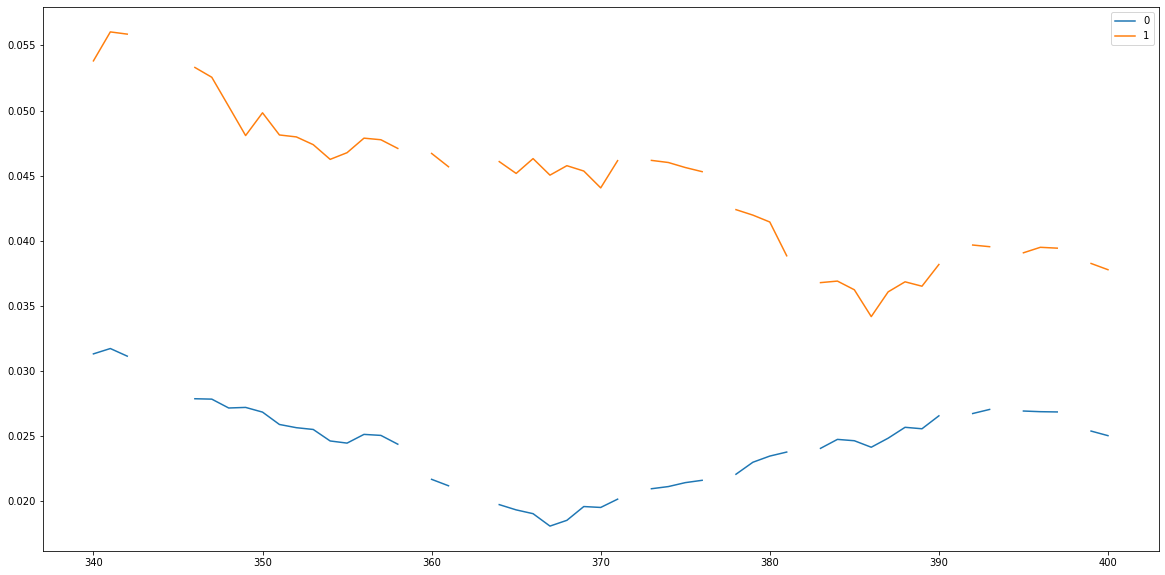

In [102]:
df_angles[340:401].plot()

<AxesSubplot:>

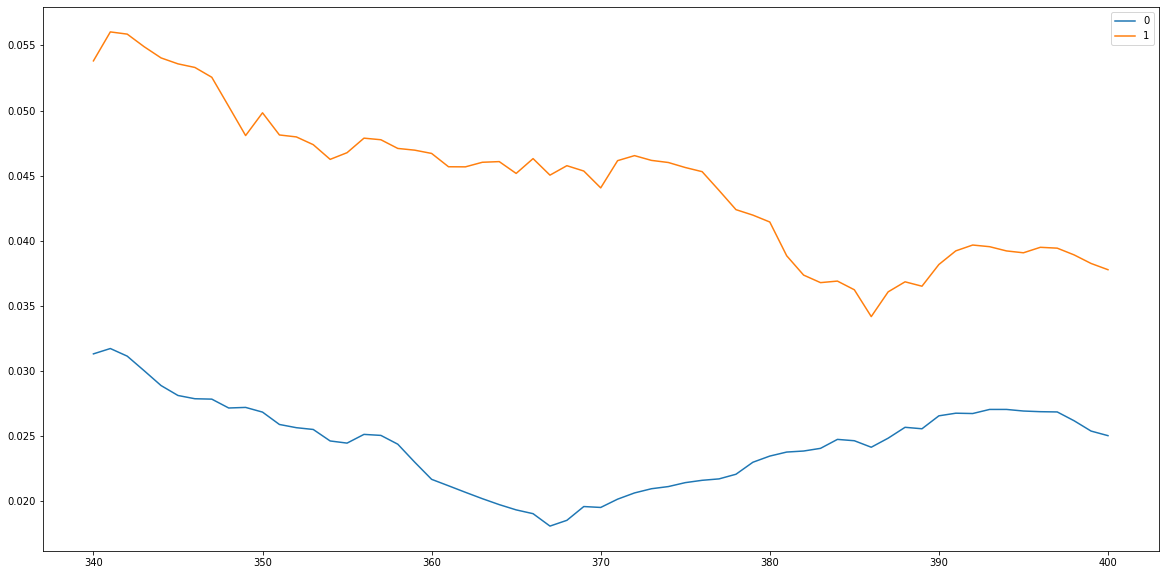

In [103]:
df_estim_angles3[340:401].plot()

In [10]:
frames = read_frames(video)

In [137]:
estim_angles[start:end] = df_estim_angles3[start:end]

In [140]:
n_width = 1164
n_height = 874
font                   = cv2.FONT_HERSHEY_SIMPLEX
original = (int(0.05 * n_width), int(n_height - (0.1 * n_height)))
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2
write_angles = True

wait_key = 141
i = 330
direction = 1

manual = False

#camera vector based straight road. (Yaw)
show_direction_v = True
scale_factor = 200
angle_factor = 20
camera_v = np.array([0, 1]).T * scale_factor
camera_v = rotate_v(camera_v, max(estim_angles[:, 1]) * angle_factor, False)
pos = np.array([int(n_width / 2), int(n_height - (0.3 * n_height))]).T

fixed_v = np.array([0, 1]).T * scale_factor
fixed_color = (0, 0, 255)

v_color = (255, 255, 255)

# cv2.namedWindow("output", cv2.WINDOW_AUTOSIZE)
# cv2.resizeWindow("output", width, height) 

while i < len(frames) and i >= 0:
    frame = np.copy(frames[i])
    
    if write_angles:
        cv2.putText(frame, f"{i} {angles[i]} {estim_angles[i]}", 
            original, 
            font, 
            fontScale,
            fontColor,
            lineType)
    
    if not math.isnan(estim_angles[i, 1]) and show_direction_v:
        v = np.copy(camera_v)
        v = inv_rotate_v(v, estim_angles[i, 1] * angle_factor, False)
        draw_arrow(frame, v, pos, v_color)
    
        cv2.putText(frame, f"{v}", 
            (int(0.05 * n_width), int(n_height - (0.2 * n_height))), 
            font, 
            fontScale,
            fontColor,
            lineType)
    
    
    frame = frame
    cv2.imshow("output", frame)

    key = cv2.waitKey(wait_key)
    if key == ord('q'):
        break
    elif key == ord('p'):
        while cv2.waitKey(500) != ord('p'):
            continue
    elif key == ord('e'): #increase speed
        if wait_key > 1: 
            wait_key -= 20
    elif key == ord('w'): #decrease speed
        if wait_key < 5001:
            wait_key += 20
    elif key == ord('a'): #forward one frame
        i -= 1
    elif key == ord('d'): #back one frame
        i += 1
    elif key == ord('m'): #manual skip
        manual = not manual
    elif key == ord('f'): #forward
        direction = 1
    elif key == ord('r'): #reverse 
        direction = -1

    if not manual:
        i += direction


        
cv2.destroyAllWindows()

In [129]:
verified_angles[start:end] = estim_angles[start:end]